In [1]:
# importing the libraries
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from IPython.display import clear_output


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/Shareddrives/ShupponKu/amazon_dataset/'

In [4]:
train_folder= os.path.join(data_dir,'training')
valid_folder= os.path.join(data_dir,'validation')
sample_folder= os.path.join(data_dir,'sample')
test_folder= os.path.join(data_dir,'sample')
num_of_training_img = len(os.listdir(train_folder + '/images')) 
num_of_training_mask = len(os.listdir(train_folder + '/masks'))
num_of_val_img = len(os.listdir(valid_folder + '/images'))
num_of_test_img = len(os.listdir(test_folder + '/images'))

In [5]:
print(f"There are {num_of_training_img} images.\n")
print(f"There are {num_of_training_mask} masks.\n")

There are 30 images.

There are 30 masks.



--BATAS SUCI--

In [6]:
train_dir=train_folder
val_dir=valid_folder
test_dir=test_folder
sample_dir = sample_folder

In [7]:
img_dim = 512
BATCH_SIZE = 1 
seed = 42

In [8]:
from PIL import Image
import random
import seaborn as sns

In [9]:
tr_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_image_generator = tr_datagen.flow_from_directory(
        train_dir,
        classes=['images'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,
)
    
train_mask_generator = tr_datagen.flow_from_directory(
        train_dir,
        classes=['masks'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)

val_image_generator = val_datagen.flow_from_directory(
        val_dir,
        classes=['images'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,

)
    
val_mask_generator = val_datagen.flow_from_directory(
        val_dir,
        classes=['masks'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)
test_image_generator = val_datagen.flow_from_directory(
        test_dir,
        classes=['images'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,

)
    
test_mask_generator = val_datagen.flow_from_directory(
        test_dir,
        classes=['masks'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)
sam_image_generator = val_datagen.flow_from_directory(
        sample_folder,
        classes=['images'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,

)
    
sam_mask_generator = val_datagen.flow_from_directory(
        sample_folder,
        classes=['masks'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)
sample_generator = zip(sam_image_generator, sam_mask_generator)

Found 30 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:193: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 30 images belonging to 1 classes.
Found 15 images belonging to 1 classes.
Found 15 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


In [10]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
        plt.axis('off')
    plt.show()

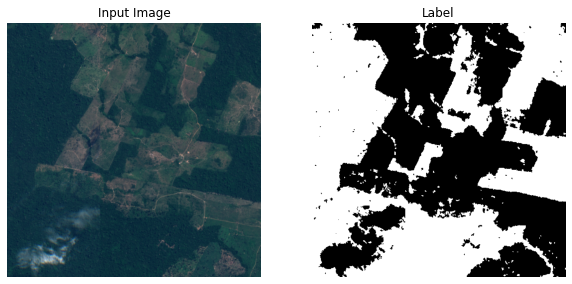

In [11]:
num_sample = 1
n = 0
# print(train_image_generator.shape)
for image, mask in sample_generator:
    sample_image, sample_label = image[0], mask[0]
    if n < num_sample:
        display([sample_image, sample_label])
        n+=1
    else:
        break

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *

In [13]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, activation='elu', kernel_initializer='he_normal', padding="same")(input)
    x = Dropout(0.1)(x)    
    x = Conv2D(num_filters, 3, activation='elu', kernel_initializer='he_normal', padding="same")(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b1 = conv_block(p4, 256)

    d1 = decoder_block(b1, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    outputs = Conv2D(1, 1, activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [14]:
from keras import backend as K

def dice_coef(y_true, y_pred):
    intersect = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    fsum = K.sum(y_true,[1,2,3])
    ssum = K.sum(y_pred,[1,2,3])
    dice = (2 * intersect ) / (fsum + ssum)
    dice = K.mean(dice)
    return dice  

def iou_coef(y_true, y_pred, smooth=0.0001):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [15]:
# defining the tensorflow distribute strategy
# strategy = tf.distribute.MirroredStrategy()

In [16]:
# # calling the model inside the scope
# with strategy.scope():
model = build_unet((img_dim, img_dim, 3))
# compiling the model with the optimizer, loss function and acc metrics
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[iou_coef,dice_coef,'accuracy', 'mse'])

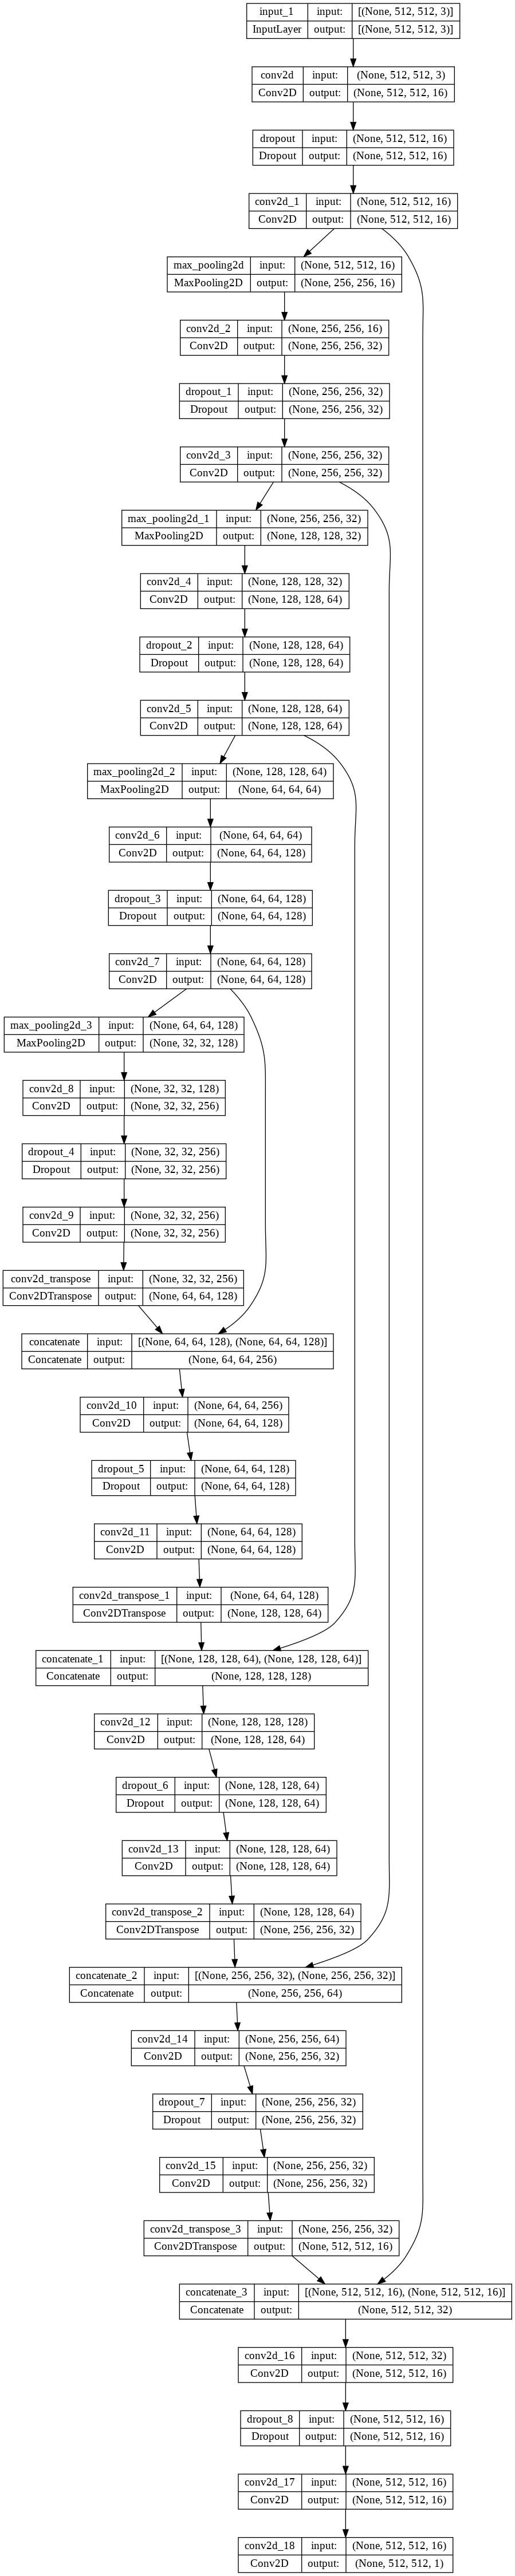

In [17]:
# let's see how our FCN implemented model looks like
# does it looks like the architecture fig above?
tf.keras.utils.plot_model(model, show_shapes=True)

In [18]:
# function to show the prediction
def show_predictions(dataset=None, num=1):
  if dataset:
    n = 0
    for image, mask in dataset:
      image, mask = image, mask
      if n < num:
        pred_mask = model.predict(image)
        print(f'image shape {image.shape}')
        print(f'mask shape {mask.shape}')
        print(f'pred_mask shape {pred_mask.shape}')
        display([image[0], mask[0],pred_mask[0]])
        n+=1
      else:
        break
  else:
    prediction = model.predict(sample_image[tf.newaxis, ...])
    display([sample_image, sample_label, prediction[0]])

1/1 [==============================] - 9s 9s/step
image shape (1, 512, 512, 3)
mask shape (1, 512, 512, 1)
pred_mask shape (1, 512, 512, 1)


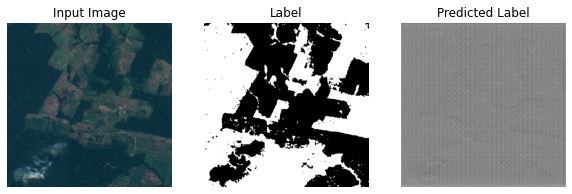

In [19]:
# # Let's see a sample of input image it's true mask and what our model is predicted given the input image
show_predictions(test_generator)

In [20]:
# calllback to displaying the predictions of our model while training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
   
 # ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0, patience = 5, verbose = 1)


In [21]:
# defining some hyperparameters
TRAIN_LENGTH = 257
#128
STEPS_PER_EPOCH = 100

EPOCHS = 50
VAL_SUBSPLITS = 5
TEST_SIZE=15
VALIDATION_STEPS = TEST_SIZE//BATCH_SIZE#//VAL_SUBSPLITS

model_history = model.fit(train_generator, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_generator,
                          callbacks=[reduce_lr]
                          )

Epoch 1/50
100/100 [==============================] - 100s 980ms/step - loss: 0.5168 - iou_coef: 0.4482 - dice_coef: 0.5903 - accuracy: 0.7174 - mse: 0.1686 - val_loss: 0.4730 - val_iou_coef: 0.5861 - val_dice_coef: 0.7009 - val_accuracy: 0.7901 - val_mse: 0.1562 - lr: 1.0000e-04
Epoch 2/50
100/100 [==============================] - 9s 95ms/step - loss: 0.2739 - iou_coef: 0.6425 - dice_coef: 0.7495 - accuracy: 0.8793 - mse: 0.0743 - val_loss: 0.4129 - val_iou_coef: 0.6537 - val_dice_coef: 0.7547 - val_accuracy: 0.8400 - val_mse: 0.1254 - lr: 1.0000e-04
Epoch 3/50
100/100 [==============================] - 11s 107ms/step - loss: 0.2478 - iou_coef: 0.6627 - dice_coef: 0.7598 - accuracy: 0.8913 - mse: 0.0650 - val_loss: 0.3821 - val_iou_coef: 0.6664 - val_dice_coef: 0.7659 - val_accuracy: 0.8580 - val_mse: 0.1121 - lr: 1.0000e-04
Epoch 4/50
100/100 [==============================] - 9s 93ms/step - loss: 0.2152 - iou_coef: 0.7015 - dice_coef: 0.7958 - accuracy: 0.9018 - mse: 0.0562 - val_l

In [22]:
model.evaluate(val_generator, steps=15)

15/15 [==============================] - 0s 18ms/step - loss: 0.2003 - iou_coef: 0.7378 - dice_coef: 0.8233 - accuracy: 0.9291 - mse: 0.0547


[0.20034553110599518,
 0.7377828359603882,
 0.8233060836791992,
 0.9290687441825867,
 0.0546768382191658]

In [23]:
model.evaluate(val_generator, steps=num_of_test_img)

1/1 [==============================] - 0s 38ms/step - loss: 0.2703 - iou_coef: 0.8232 - dice_coef: 0.9030 - accuracy: 0.9105 - mse: 0.0719


[0.2703416347503662,
 0.823157548904419,
 0.9030020833015442,
 0.9104843139648438,
 0.07191786170005798]

1/1 [==============================] - 0s 18ms/step
image shape (1, 512, 512, 3)
mask shape (1, 512, 512, 1)
pred_mask shape (1, 512, 512, 1)


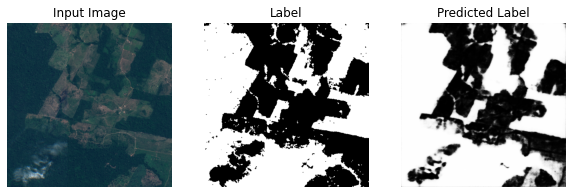

In [24]:
show_predictions(sample_generator)

1/1 [==============================] - 0s 26ms/step
image shape (1, 512, 512, 3)
mask shape (1, 512, 512, 1)
pred_mask shape (1, 512, 512, 1)


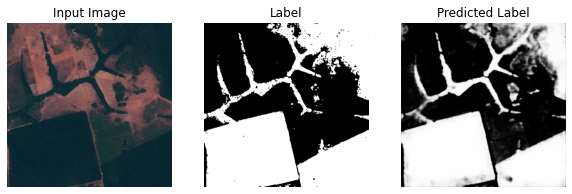

1/1 [==============================] - 0s 21ms/step
image shape (1, 512, 512, 3)
mask shape (1, 512, 512, 1)
pred_mask shape (1, 512, 512, 1)


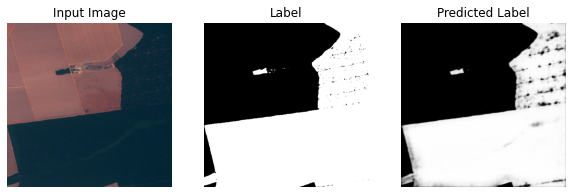

1/1 [==============================] - 0s 21ms/step
image shape (1, 512, 512, 3)
mask shape (1, 512, 512, 1)
pred_mask shape (1, 512, 512, 1)


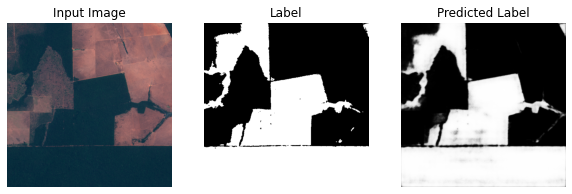

1/1 [==============================] - 0s 18ms/step
image shape (1, 512, 512, 3)
mask shape (1, 512, 512, 1)
pred_mask shape (1, 512, 512, 1)


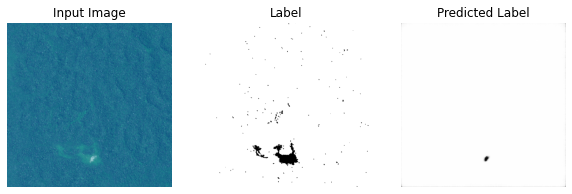

1/1 [==============================] - 0s 18ms/step
image shape (1, 512, 512, 3)
mask shape (1, 512, 512, 1)
pred_mask shape (1, 512, 512, 1)


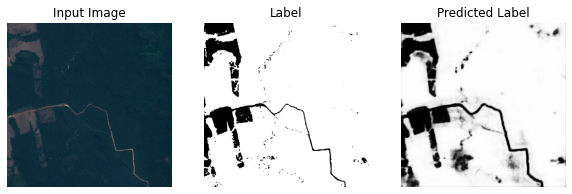

In [25]:
show_predictions(val_generator, 5)

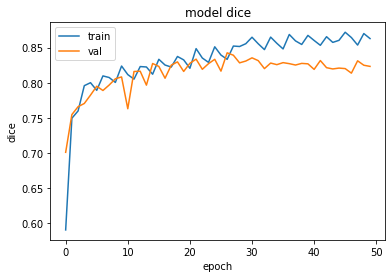

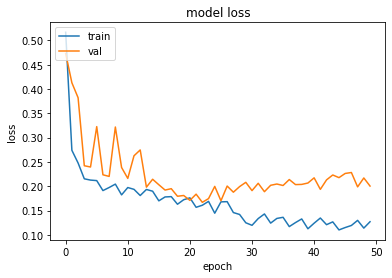

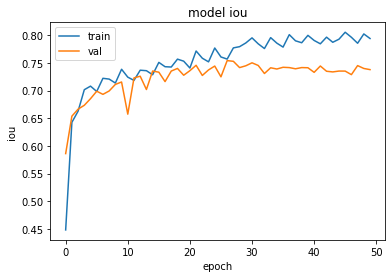

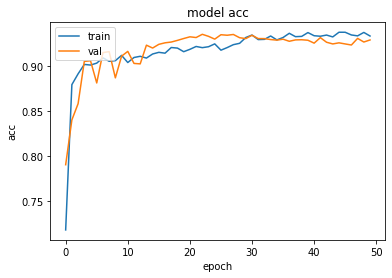

In [26]:
#dice
plt.plot(model_history.history['dice_coef'])
plt.plot(model_history.history['val_dice_coef'])
plt.title('model dice')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#iou
plt.plot(model_history.history['iou_coef'])
plt.plot(model_history.history['val_iou_coef'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
model.save('unet-c1-iou-norm.h5')